<a href="https://colab.research.google.com/github/srinivasanprashant/yoga-pose-classifier/blob/master/classifying_yoga_poses.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classifying Yoga Poses using FastAI and Resnet-34 CNN

In [1]:
  !curl -s https://course.fast.ai/setup/colab | bash

Updating fastai...
Done.


As a follow up to my previous work, I wanted to build another image classifier using a training set of images of people doing yoga poses, and see if we can achieve reasonable results. This training set was approximately 50-60 images per pose in various settings. The validation set is approximately 10-15 per pose.

At some point we may then add to this limited image set and see if that results in further improvments to the model's accuracy. Also I would like to deploy this to a web-app for real-life testing.

First lets start off with some code to allow my folders containing training/test images from google drive to load and some code to ensure that any edits to libraries are reloaded here automatically, and also that any charts or images displayed are shown in this notebook.

In [2]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'fastai-v3/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

We import all the necessary packages. We are going to work with the [fastai V1 library](http://www.fast.ai/2018/10/02/fastai-ai/) which sits on top of [Pytorch 1.0](https://hackernoon.com/pytorch-1-0-468332ba5163). The fastai library provides many useful functions that enable us to quickly and easily build neural networks and train our models.

In [0]:
from fastai.vision import *
from fastai.metrics import error_rate

If you're using a computer with an unusually small GPU, you may get an out of memory error when running this notebook. If this happens, click Kernel->Restart, uncomment the 2nd line below to use a smaller *batch size*, and try again.

In [0]:
bs = 64
# bs = 16   # uncomment this line if you run out of memory even after clicking Kernel->Restart

## Looking at the data

We are going to use images of yoga poses from google. There are approximately 1000 images spread across 10 poses. Our model will need to learn to differentiate between these categories. I would like to see an error rate below 10% for several iterations of the tests but it might not be possible with the dataset at present.  Let's see how accurate we can be using deep learning! 

In [7]:
# Adding the correct path to base_dir to access the images on Google Drive
path = Path(base_dir + "yoga-poses")
path

PosixPath('/content/gdrive/My Drive/fastai-v3/yoga-poses')

In [8]:
path.ls()

[PosixPath('/content/gdrive/My Drive/fastai-v3/yoga-poses/train'),
 PosixPath('/content/gdrive/My Drive/fastai-v3/yoga-poses/valid'),
 PosixPath('/content/gdrive/My Drive/fastai-v3/yoga-poses/models')]

In [0]:
# path_img = path/'Ski'
# print(path_img)

The first thing we do when we approach a problem is to take a look at the data. We _always_ need to understand very well what the problem is and what the data looks like before we can figure out how to solve it. Taking a look at the data means understanding how the data directories are structured, what the labels are and what some sample images look like.

The main difference between the handling of image classification datasets is the way labels are stored. In this particular dataset, labels are stored in the filenames themselves. We will need to extract them to be able to classify the images into the correct categories. Fortunately, the fastai library has a handy function made exactly for this, `ImageDataBunch.from_name_re` gets the labels from the filenames using a [regular expression](https://docs.python.org/3.6/library/re.html).

In [0]:
# np.random.seed(2)
# pat = r'/([^/]+)_\d+.jpg$'
# print(pat)

In [0]:
#tfms = get_transforms(do_flip=False)

In [0]:
# data = ImageDataBunch.from_folder(path, ds_tfms=get_transforms(), size=224, bs=bs//4).normalize(imagenet_stats)
data = ImageDataBunch.from_folder(path, ds_tfms=get_transforms(), 
                                  size=224, bs=bs).normalize(imagenet_stats)


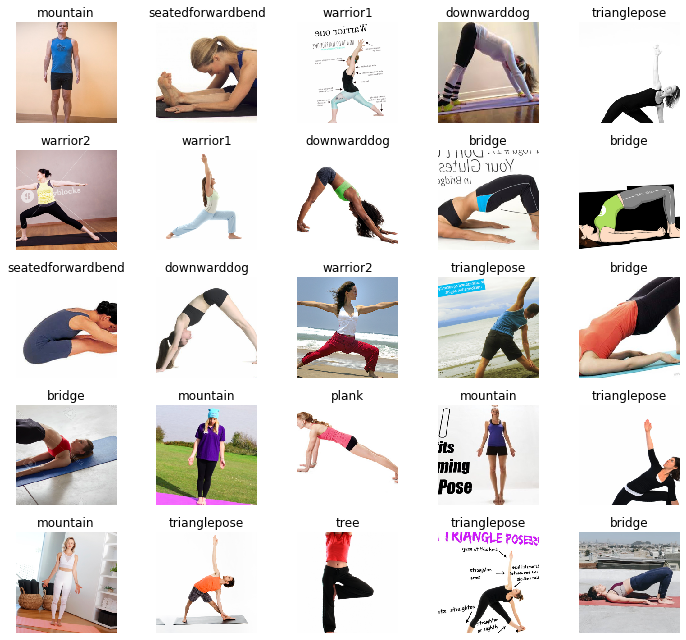

In [13]:
data.show_batch(rows=5, figsize=(10,9))

In [14]:
print(data.classes)
len(data.classes),data.c

['bridge', 'childs', 'downwarddog', 'mountain', 'plank', 'seatedforwardbend', 'tree', 'trianglepose', 'warrior1', 'warrior2']


(10, 10)

## Training: resnet34

Now we will start training our model. We will use a [convolutional neural network](http://cs231n.github.io/convolutional-networks/) backbone and a fully connected head with a single hidden layer as a classifier. Don't know what these things mean? Not to worry, we will dive deeper in the coming lessons. For the moment you need to know that we are building a model which will take images as input and will output the predicted probability for each of the categories (in this case, it will have 37 outputs).

We will train for 4 epochs (4 cycles through all our data).

In [15]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:04<00:00, 20.3MB/s]


In [16]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

In [17]:
learn.fit_one_cycle(2)

epoch,train_loss,valid_loss,error_rate,time
0,2.953326,1.217529,0.432000,02:26
1,1.792507,0.772962,0.256000,00:36


In [0]:
learn.save('stage-1-yoga')

## Results

Let's see what results we have got. With very little work, we are at 75% accuracy per the tests already. This is a good sign.

> epoch	train_loss	valid_loss	error_rate	time

> 0	2.953326	1.217529	0.432000	02:26

> 1	1.792507	0.772962	0.256000	00:36


We will first see which were the categories that the model most confused with one another. We will try to see if what the model predicted was reasonable or not. In this case the mistakes look reasonable (none of the mistakes seems obviously naive). This is an indicator that our classifier is working correctly. 

Furthermore, when we plot the confusion matrix, we can see that the distribution is heavily skewed: the model makes the same mistakes over and over again but it rarely confuses other categories. This suggests that it just finds it difficult to distinguish some specific poses between each other; this is normal behavior.

For example, plank/downward-dog, childs/bridge, and warrior1/warrior2.

In [19]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

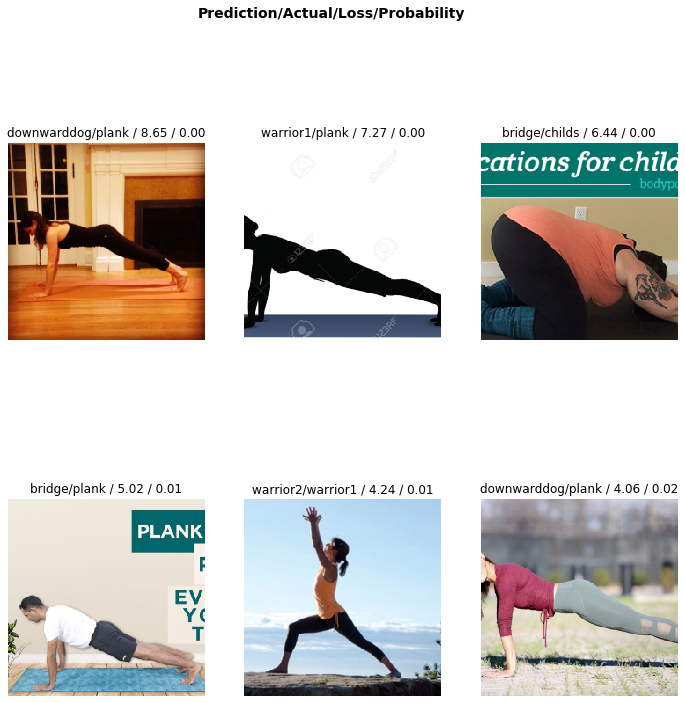

In [20]:
interp.plot_top_losses(6)

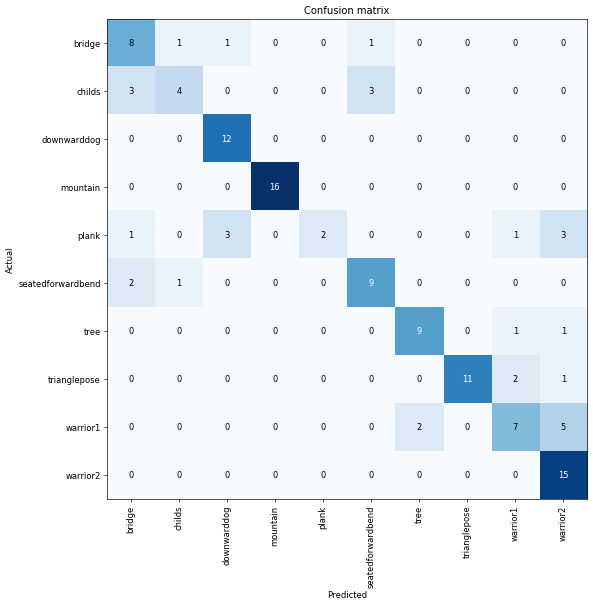

In [22]:
interp.plot_confusion_matrix(figsize=(10,10), dpi=60)

In [23]:
interp.most_confused(min_val=1)

[('warrior1', 'warrior2', 5),
 ('childs', 'bridge', 3),
 ('childs', 'seatedforwardbend', 3),
 ('plank', 'downwarddog', 3),
 ('plank', 'warrior2', 3),
 ('seatedforwardbend', 'bridge', 2),
 ('trianglepose', 'warrior1', 2),
 ('warrior1', 'tree', 2),
 ('bridge', 'childs', 1),
 ('bridge', 'downwarddog', 1),
 ('bridge', 'seatedforwardbend', 1),
 ('plank', 'bridge', 1),
 ('plank', 'warrior1', 1),
 ('seatedforwardbend', 'childs', 1),
 ('tree', 'warrior1', 1),
 ('tree', 'warrior2', 1),
 ('trianglepose', 'warrior2', 1)]

## Unfreezing, fine-tuning, and learning rates

Since our model is working as we expect it to, we will *unfreeze* our model and train some more.

In [0]:
learn.load('stage-1-yoga');

In [25]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


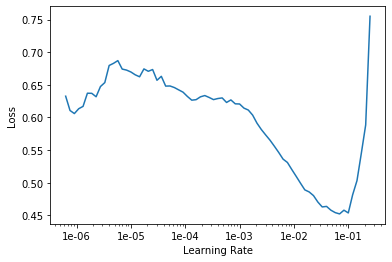

In [26]:
learn.recorder.plot()

In [27]:
learn.unfreeze()
learn.fit_one_cycle(4, max_lr=slice(1e-5,1e-2))

epoch,train_loss,valid_loss,error_rate,time
0,0.503671,0.436510,0.128000,00:27
1,0.362925,1.170754,0.184000,00:26
2,0.338296,0.639974,0.096000,00:26
3,0.269352,0.509307,0.088000,00:26


Wow, I think that is a very accurate classifier given the small number of images for the training set and the fact that almost all images are not sized properly so part of the yoga pose might be cropped. 




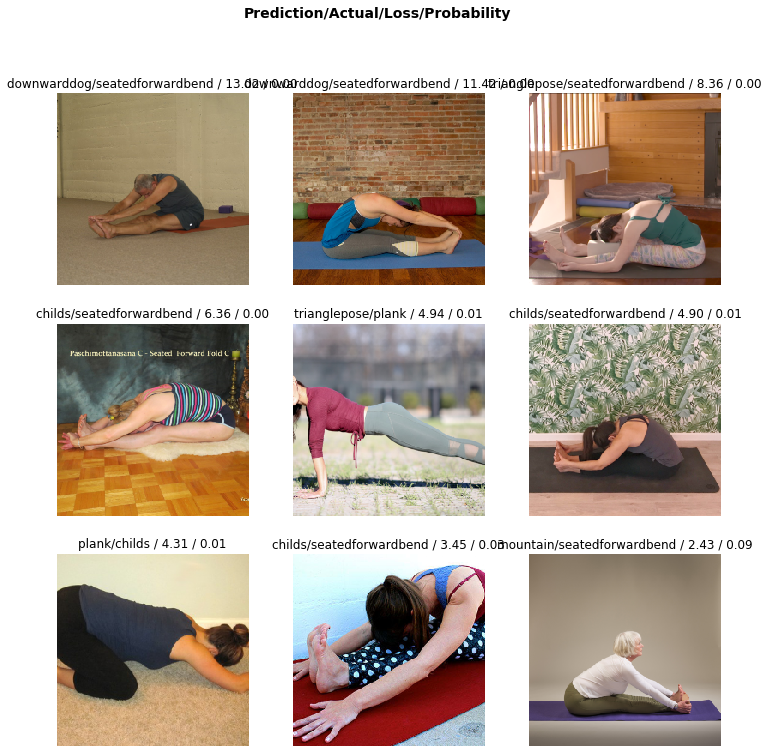

In [28]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_top_losses(9)

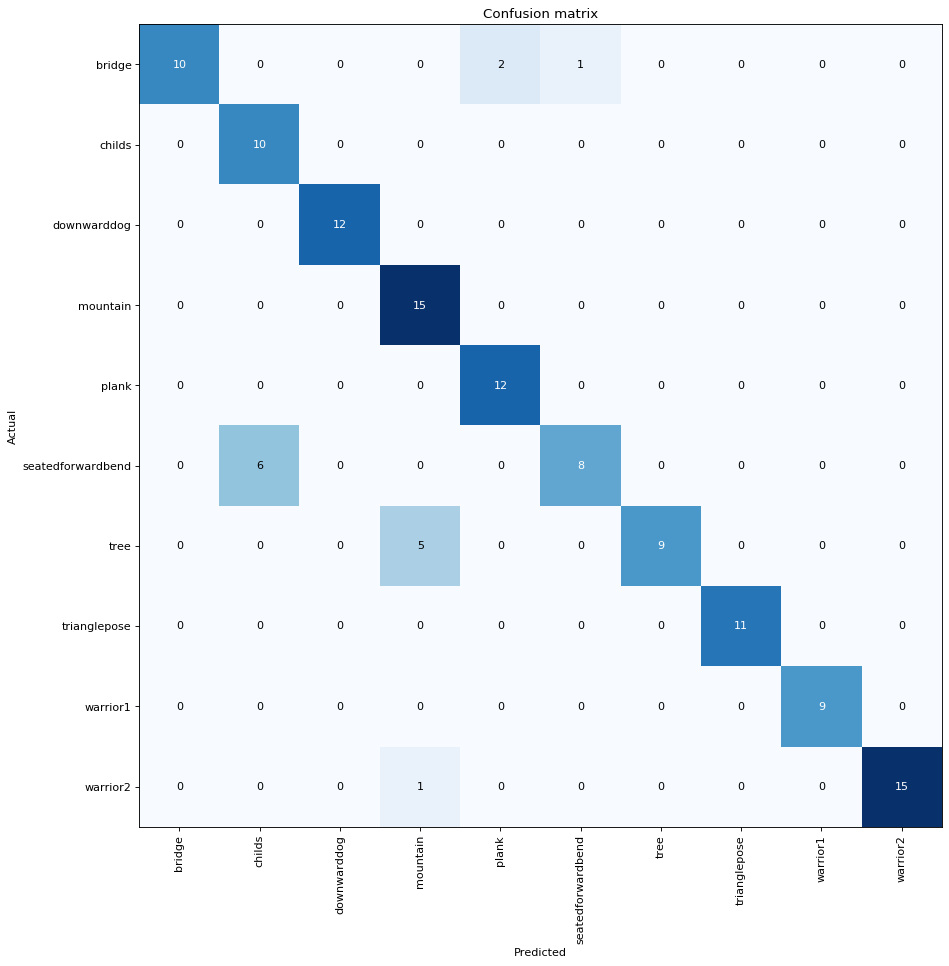

In [0]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=80)

In [0]:
learn.save('stage-2-yoga')

## Training: resnet50

Now we will train in the same way as before but with one caveat: instead of using resnet34 as our backbone we will use resnet50 (resnet34 is a 34 layer residual network while resnet50 has 50 layers. It will be explained later in the course and you can learn the details in the [resnet paper](https://arxiv.org/pdf/1512.03385.pdf)).

Basically, resnet50 usually performs better because it is a deeper network with more parameters. Let's see if we can achieve a higher performance here. To help it along, let's us use larger images too, since that way the network can see more detail. We reduce the batch size a bit since otherwise this larger network will require more GPU memory.

In [0]:
data = ImageDataBunch.from_folder(path, ds_tfms=get_transforms(), 
                                  size=224, bs=16).normalize(imagenet_stats)

In [29]:
learn = cnn_learner(data, models.resnet50, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth
100%|██████████| 97.8M/97.8M [00:04<00:00, 23.3MB/s]


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


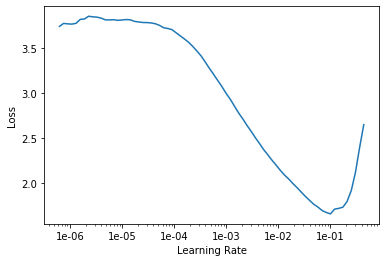

In [31]:
learn.lr_find()
learn.recorder.plot()

In [32]:
learn.fit_one_cycle(2)

epoch,train_loss,valid_loss,error_rate,time
0,2.246032,1.069708,0.320000,00:31
1,1.291836,0.663838,0.216000,00:27


Error rates are pretty high.

In [35]:
learn.unfreeze()
learn.fit_one_cycle(4, max_lr=slice(1e-5,1e-2))

epoch,train_loss,valid_loss,error_rate,time
0,0.145536,0.521041,0.080000,00:30
1,0.149763,0.669540,0.064000,00:29
2,0.145204,0.588693,0.088000,00:29
3,0.124926,0.314873,0.064000,00:28


In [0]:
learn.save('stage-3-yoga')

That is a very good classifier based on the work we have done so far.

We have only done a bit of basic cleaning up on the training images but there are still poor images in the training set as well as in the validation set. Also, there are not enough images to some of the classifications that are problematic - child/seated-forward-bend and plank/bridge. In the future, I could revisit those poses and source more sample images for training and validation.

The confusion matrix (plotted at the very bottom) is a great way to see where the model is having challenges, and it may indicate where to focus future  resources.

In [0]:
# If the model is not much better, then it might be useful to just go back to the older model we saved.
# learn.load('stage-2-yoga');

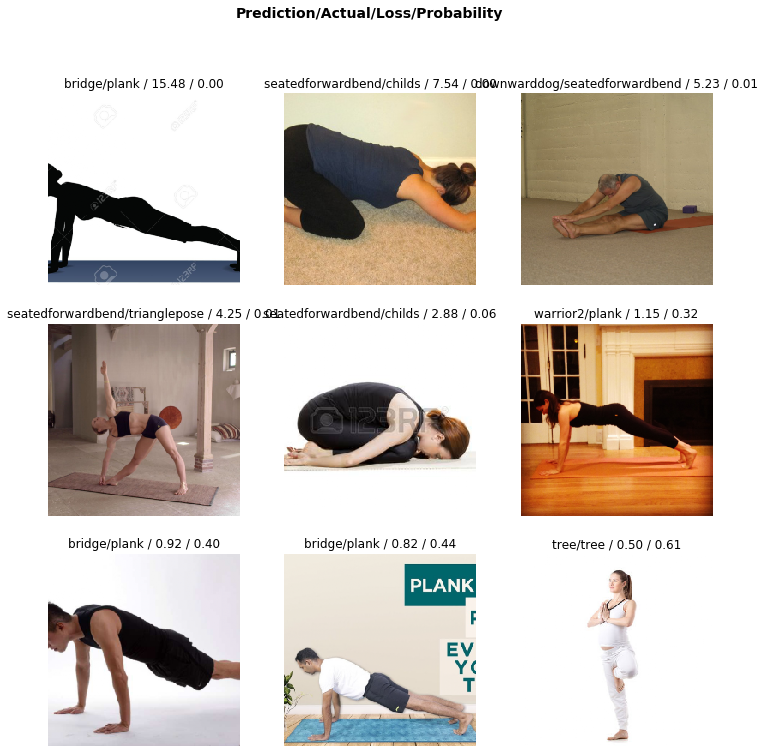

In [37]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_top_losses(9)

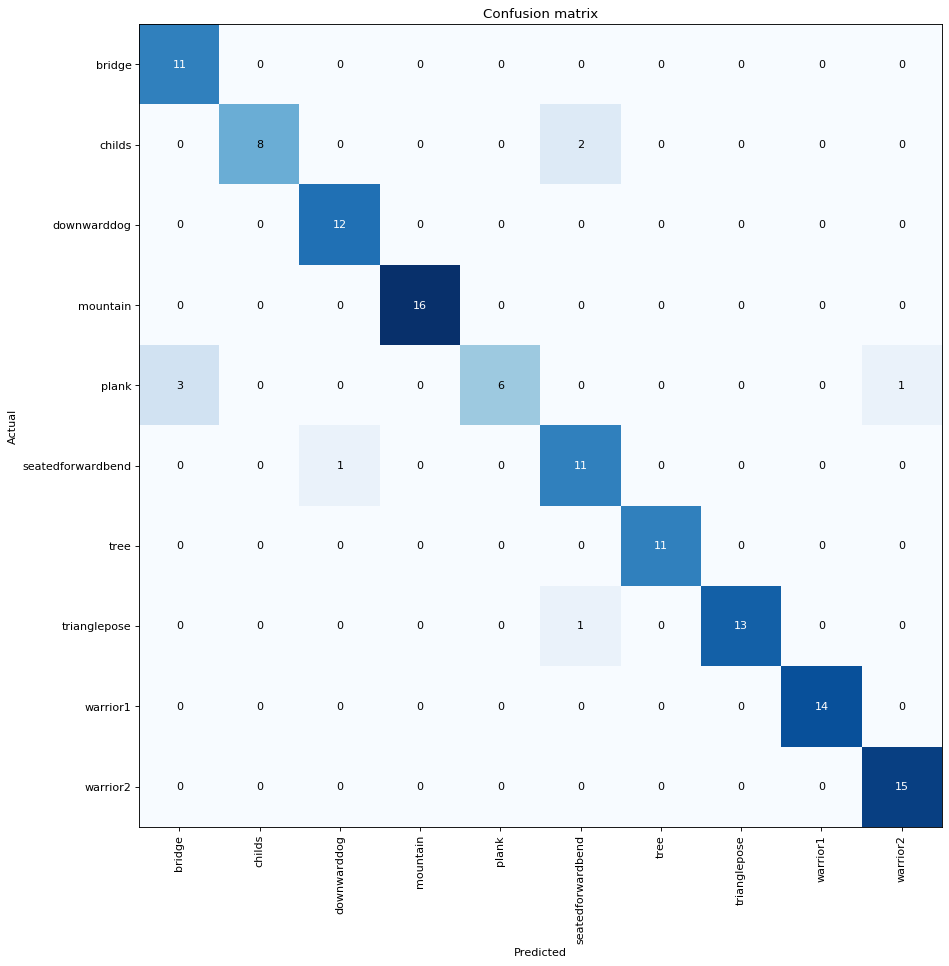

In [38]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=80)